In [48]:
%config IPCompleter.greedy=True
%matplotlib inline
import random

In [49]:
from csv import reader

def read_csv(path):
    dataset = list()
    with open(path, 'r') as rf:
        for line in rf:
            line = " ".join(line.split())
            line = line.split(' ')
            dataset.append(line)
            convert_to_float(line)
    
    return dataset

In [50]:
def convert_to_float(line):
    for i in range(len(line) - 1):
        line[i] = float(line[i])

In [51]:
dataset = read_csv('seeds_dataset.csv')


In [52]:
dataset

[[15.26, 14.84, 0.871, 5.763, 3.312, 2.221, 5.22, '1'],
 [14.88, 14.57, 0.8811, 5.554, 3.333, 1.018, 4.956, '1'],
 [14.29, 14.09, 0.905, 5.291, 3.337, 2.699, 4.825, '1'],
 [13.84, 13.94, 0.8955, 5.324, 3.379, 2.259, 4.805, '1'],
 [16.14, 14.99, 0.9034, 5.658, 3.562, 1.355, 5.175, '1'],
 [14.38, 14.21, 0.8951, 5.386, 3.312, 2.462, 4.956, '1'],
 [14.69, 14.49, 0.8799, 5.563, 3.259, 3.586, 5.219, '1'],
 [14.11, 14.1, 0.8911, 5.42, 3.302, 2.7, 5.0, '1'],
 [16.63, 15.46, 0.8747, 6.053, 3.465, 2.04, 5.877, '1'],
 [16.44, 15.25, 0.888, 5.884, 3.505, 1.969, 5.533, '1'],
 [15.26, 14.85, 0.8696, 5.714, 3.242, 4.543, 5.314, '1'],
 [14.03, 14.16, 0.8796, 5.438, 3.201, 1.717, 5.001, '1'],
 [13.89, 14.02, 0.888, 5.439, 3.199, 3.986, 4.738, '1'],
 [13.78, 14.06, 0.8759, 5.479, 3.156, 3.136, 4.872, '1'],
 [13.74, 14.05, 0.8744, 5.482, 3.114, 2.932, 4.825, '1'],
 [14.59, 14.28, 0.8993, 5.351, 3.333, 4.185, 4.781, '1'],
 [13.99, 13.83, 0.9183, 5.119, 3.383, 5.234, 4.781, '1'],
 [15.69, 14.75, 0.9058, 5.

###### Drzewa decyzyjne
1. Posortować dane w danej kolumnie
2. Obliczyć średnią dla każdych przyległych wartości
3. Dla każdej z obliczonych średnich wyliczyć Gini
4. Wybrać najmniejszą wartość Gini i podzielić wg tej wartości

In [78]:
class Node():
    
    def __init__(self, values, all_classes, num_of_attributes, all_attributes, depth, max_depth, min_size, is_terminal):
        self.values = values
        self.all_classes = all_classes
        self.num_of_attributes = num_of_attributes
        self.all_attributes = all_attributes
        self.possible_split_attributes = random.sample(self.all_attributes, k=self.num_of_attributes) # Use only a random subset of attributes of dataset
        self.grp_count = self.count_grps()
        self.depth = depth
        self.max_depth = max_depth
        self.min_size = min_size
        self.left = None
        self.right = None
        self.gini_index = 1
        self.split_attribute = None
        self.split_value = None
        self.is_terminal = is_terminal
        self.pred_class = self.pred_class()
        if not self.is_terminal:
            self.pick_best_split()
        
    def count_grps(self):
        grps = [i[-1] for i in self.values]
        count = [grps.count(j) for j in self.all_classes]
        return count
    
    def pred_class(self):
        grps = [i[-1] for i in self.values]
        return max(set(grps), key=grps.count)
    
    def pick_best_split(self):
        tmp_left = None
        tmp_right = None
        for attribute in self.possible_split_attributes:
            for row in range(len(self.values)):
                lower, higher = self.split(attribute, row)
                gini = gini_index([lower, higher], self.all_classes)
                if gini < self.gini_index:
                    self.gini_index = gini
                    self.split_attribute = attribute
                    self.split_value = self.values[row][attribute]
                    tmp_left = lower
                    tmp_right = higher
                    
        self.make_new_node(tmp_left, tmp_right)
        

    def make_new_node(self, left, right):
        if not left or not right or self.gini_index == 0:
            # No more splits possible1
            self.is_terminal = True
            return
        
        if len(self.values) <= self.min_size:
            self.is_terminal = True
            return
        
        if self.depth == self.max_depth:
            self.is_terminal = True
            return
        
        self.left = Node(left, self.all_classes, self.num_of_attributes, self.all_attributes, self.depth + 1, self.max_depth, self.min_size, False)
        self.right = Node(right, self.all_classes, self.num_of_attributes, self.all_attributes, self.depth + 1, self.max_depth, self.min_size, False)
        
        
    def split(self, attribute, row):
        lower = list()
        higher = list()
        for i in range(len(self.values)):
            if self.values[i][attribute] < self.values[row][attribute]:
                lower.append(self.values[i])
            else:
                higher.append(self.values[i])
        return lower, higher
    
    def __str__(self):
        return f"Split attribute:{self.split_attribute}, Gini:{self.gini_index}, Samples:{len(self.values)}, Groups:{self.grp_count}, Class:{self.pred_class}, Split value:{self.split_value}, Depth:{self.depth}"

In [79]:
def gini_index(splitted_grps, all_classes):
    result = 0
    total_size = sum([len(i) for i in splitted_grps])
    for grp in splitted_grps:
        grp_prob = 0
        for i in all_classes:
            if not len(grp):
                continue
            class_prob = [row[-1] for row in grp].count(i) / len(grp)
            grp_prob += class_prob**2
        result += (1 - grp_prob) * (len(grp) / total_size)
    return float("{:.2f}".format(result))

In [80]:
class DecisionTree():
    
    def __init__(self, dataset, max_depth, min_node_size, num_of_attributes, all_attributes):
        self.dataset = dataset
        self.max_depth = max_depth
        self.min_node_size = min_node_size
        self.num_of_attributes = num_of_attributes
        self.all_attributes = all_attributes
        self.all_classes = list(set([i[-1] for i in dataset]))
        self.root = Node(self.dataset, self.all_classes, self.num_of_attributes, self.all_attributes, 1, max_depth, min_node_size, False)
        
    def visualize(self):
        queue = list()
        queue.append(self.root)
        
        while queue:
            v = queue.pop(0)
            print(v)
            if v.left is not None:
                queue.append(v.left)
            if v.left is not None:
                queue.append(v.right)
                
    def predict(self, row):
        current_node = self.root
        current_predicted_class = None
        while current_node is not None:
            current_predicted_class = current_node.pred_class
            if row[current_node.split_attribute] < current_node.split_value:
                current_node = current_node.left
            else:
                current_node = current_node.right
        return current_predicted_class
        
        

In [81]:
dec_tree = DecisionTree(dataset, 10, 10, 7, [0, 1, 2, 3, 4, 5, 6])
dec_tree.visualize()

Split attribute:6, Gini:0.35, Samples:210, Groups:[70, 70, 70], Class:2, Split value:5.618, Depth:1
Split attribute:0, Gini:0.19, Samples:141, Groups:[2, 69, 70], Class:3, Split value:13.45, Depth:2
Split attribute:5, Gini:0.02, Samples:69, Groups:[68, 1, 0], Class:2, Split value:2.068, Depth:2
Split attribute:6, Gini:0.17, Samples:84, Groups:[0, 14, 70], Class:3, Split value:4.794, Depth:3
Split attribute:4, Gini:0.05, Samples:57, Groups:[2, 55, 0], Class:1, Split value:3.582, Depth:3
Split attribute:3, Gini:0.0, Samples:6, Groups:[5, 1, 0], Class:2, Split value:6.084, Depth:3
Split attribute:0, Gini:0.0, Samples:63, Groups:[63, 0, 0], Class:2, Split value:17.63, Depth:3
Split attribute:3, Gini:0.12, Samples:8, Groups:[0, 7, 1], Class:1, Split value:5.008, Depth:4
Split attribute:5, Gini:0.12, Samples:76, Groups:[0, 7, 69], Class:3, Split value:1.661, Depth:4
Split attribute:2, Gini:0.03, Samples:55, Groups:[1, 54, 0], Class:1, Split value:0.8955, Depth:4
Split attribute:2, Gini:0.0, 

###### Las losowy
1. Stworzyć "bootstrapped" zbiór danych
2. Stworzyć drzewo decyzyjne używając bootstrapped zbioru danych ale w każdym kroku rozważamy tylko losowo wybrane kolumny(odrzucamy po wybraniu)

In [57]:
class RandomForest():
    
    def __init__(self, dataset, num_of_trees, max_depth, min_node_size, num_of_attributes):
        self.dataset = dataset
        self.num_of_trees = num_of_trees
        self.max_depth = max_depth
        self.min_node_size = min_node_size
        self.num_of_attributes = num_of_attributes
        self.all_attributes = [i for i in range(len(self.dataset[0]) - 1)]
        self.trees = list()
        
        for i in range(num_of_trees):
            self.trees.append(self.create_tree())
         
    def bootstrap_data(self):
        return random.choices(self.dataset, k=len(self.dataset))
    
    def create_tree(self):
        data = self.bootstrap_data()
        return DecisionTree(data, self.max_depth, self.min_node_size, self.num_of_attributes, self.all_attributes)
        
    def predict(self, row):
        predictions = dict()
        for tree in self.trees:
            pred = tree.predict(row)
            if pred not in predictions.keys():
                predictions[pred] = 0
            predictions[pred] += 1
        return self.max_predict(predictions)
        
    def max_predict(self, predictions):
        maximal_pred = float('-inf')
        for key in predictions.keys():
            if predictions[key] > float(maximal_pred):
                maximal_pred = key
                
        return maximal_pred
        

##### Testowanie

In [58]:
def cross_validation_split(dataset, n_folds):
    splitted = list()
    dataset_cp = dataset.copy()
    fold_size = len(dataset) // n_folds
    for i in range(n_folds):
        fold = list()
        for i in range(fold_size):
            choice = random.randrange(len(dataset_cp))
            fold.append(dataset_cp.pop(choice))
        splitted.append(fold)
    return splitted
        
        

In [59]:
def test_performance(dataset, num_of_folds, num_of_trees, max_depth, min_node_size, num_of_attributes):
    folds = cross_validation_split(dataset, num_of_folds)
    performance = 0
    for i in range(num_of_folds):
        fold_performance = 0
        folds_cp = folds.copy()
        test = folds_cp.pop(i)
        train = [row for group in folds_cp for row in group]
        rand_forest = RandomForest(train, num_of_trees, max_depth, min_node_size, num_of_attributes)
        y_true = [row[-1] for row in test]
        y_pred = [rand_forest.predict(row) for row in test]
        for j in range(len(y_true)):
            if y_true[j] == y_pred[j]:
                fold_performance += 1
        performance += fold_performance / len(y_true)
    performance /= num_of_folds
    return float("{:.2f}".format(performance))

In [60]:
test_performance(dataset, 2, 2, 10, 2, 4)

0.83

In [61]:
def sensitivity(matrix):
    sens_a = matrix[0][0] / sum(matrix[0])
    sens_b = matrix[1][1] / sum(matrix[1])
    sens_c = matrix[2][2] / sum(matrix[2])
    return sens_a, sens_b, sens_c 

def precision(matrix):
    prec_a = matrix[0][0] / (matrix[0][0] + matrix[1][0] + matrix[2][0])
    prec_b = matrix[1][1] / (matrix[0][1] + matrix[1][1] + matrix[2][1])
    prec_c = matrix[2][2] / (matrix[0][2] + matrix[1][2] + matrix[2][2])
    return prec_a, prec_b, prec_c

In [73]:
"""
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

"""
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [74]:
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import itertools

def make_confusion_matrix(dataset, num_of_folds, num_of_trees, max_depth, min_node_size, num_of_attributes):
    avg_matrix = np.zeros(shape=(3, 3), dtype=int)
    classes = ['1', '2', '3']
    folds = cross_validation_split(dataset, num_of_folds)
    for i in range(num_of_folds):
        folds_cp = folds.copy()
        test = folds_cp.pop(i)
        train = [row for group in folds_cp for row in group]
        rand_forest = RandomForest(train, num_of_trees, max_depth, min_node_size, num_of_attributes)
        y_true = [row[-1] for row in test]
        y_pred = [rand_forest.predict(row) for row in test]
        matrix = confusion_matrix(y_true, y_pred, labels=classes)
        avg_matrix += matrix
        
    avg_matrix //= num_of_folds

    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(avg_matrix, classes=classes,
                      title='Confusion matrix')

    sens_a, sens_b, sens_c = sensitivity(avg_matrix)
    print(f"sensitivity_A={sens_a}, sensitivity_B={sens_b}, sensitivity_C={sens_c}")
    prec_a, prec_b, prec_c = precision(avg_matrix)
    print(f"precision_A={prec_a}, precision_B={prec_b}, precision_C={prec_c}")
    accuracy = (avg_matrix[0][0] + avg_matrix[1][1] + avg_matrix[2][2]) / (sum(avg_matrix[0]) + sum(avg_matrix[1]) + sum(avg_matrix[2]))
    print(f"accuracy={accuracy}")

    return avg_matrix

Confusion matrix, without normalization
[[5 0 1]
 [0 6 0]
 [0 0 6]]


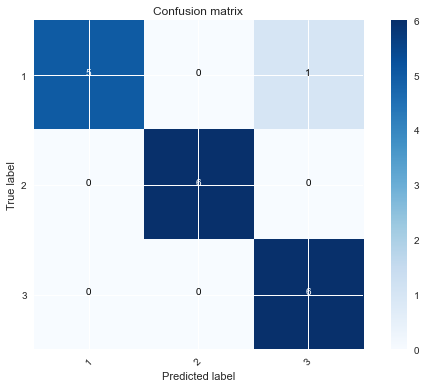

sensitivity_A=0.8333333333333334, sensitivity_B=1.0, sensitivity_C=1.0
precision_A=1.0, precision_B=1.0, precision_C=0.8571428571428571
accuracy=0.9444444444444444


array([[5, 0, 1],
       [0, 6, 0],
       [0, 0, 6]])

In [77]:
make_confusion_matrix(dataset, 10, 2, 10, 2, 4)

###### Wykresy zależności danych


In [65]:
def get_all_attributes(dataset):
    area = list()
    perimeter = list()
    compactness = list()
    len_of_kernel = list()
    width_of_kernel = list()
    asymmetry_coefficient = list()
    len_of_kernel_groove = list()
    
    for row in dataset:
        area.append(row[0])
        perimeter.append(row[1])
        compactness.append(row[2])
        len_of_kernel.append(row[3])
        width_of_kernel.append(row[4])
        asymmetry_coefficient.append(row[5])
        len_of_kernel_groove.append(row[6])
    return area, perimeter, compactness, len_of_kernel, width_of_kernel, asymmetry_coefficient, len_of_kernel_groove

In [66]:
area, perimeter, compactness, len_of_kernel, width_of_kernel, asymmetry_coefficient, len_of_kernel_groove = get_all_attributes(dataset)

In [67]:
from matplotlib import pyplot as plt

def plot_parameters(param1, param2, xlabel, ylabel, title):
    plt.style.use('seaborn')

    plt.scatter(param1[:70], param2[:70], c='blue', label='Kama', edgecolors='black', linewidths=0.5)
    plt.scatter(param1[70:2*70], param2[70:2*70], c='green', label='Rosa', edgecolors='black', linewidths=0.5)
    plt.scatter(param1[2*70:], param2[2*70:], c='red', label='Canadian', edgecolors='black', linewidths=0.5)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

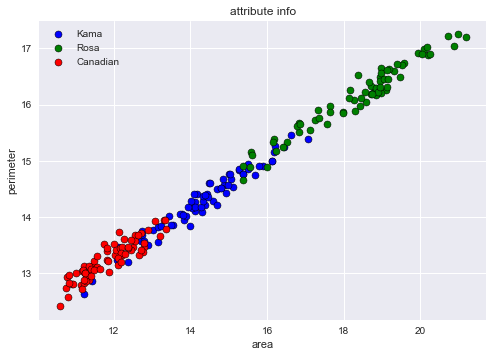

In [68]:
plot_parameters(area, perimeter, 'area', 'perimeter', 'attribute info')

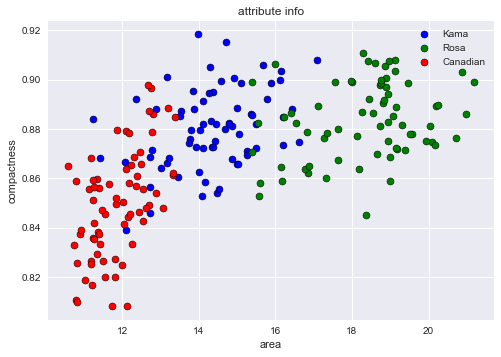

In [69]:
plot_parameters(area, compactness, 'area', 'compactness', 'attribute info')

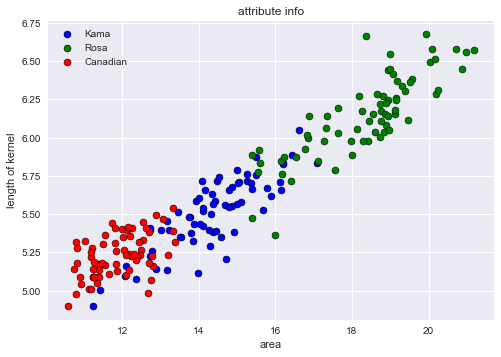

In [70]:
plot_parameters(area, len_of_kernel, 'area', 'length of kernel', 'attribute info')

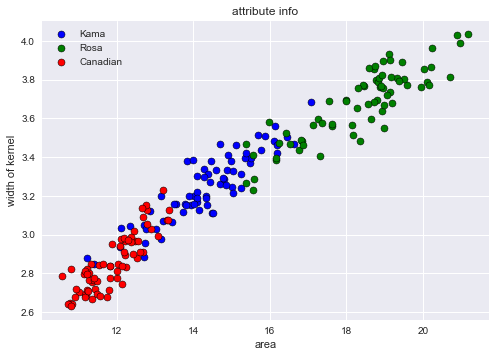

In [71]:
plot_parameters(area, width_of_kernel, 'area', 'width of kernel', 'attribute info')